# Libraries

In [95]:
## libraries
import sys
import os
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import re
import numpy as np
from math import cos, asin, sqrt
import time
from difflib import SequenceMatcher


%matplotlib inline

# to import Database class from data_collection folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# now that the folder is in the path, ../data_collection/database.py can be imported
from database import Database

# List of Restaurants-of-Interest

- 5092 reviews contained the word Halal were scraped
- These reviews are from 838 restaurants


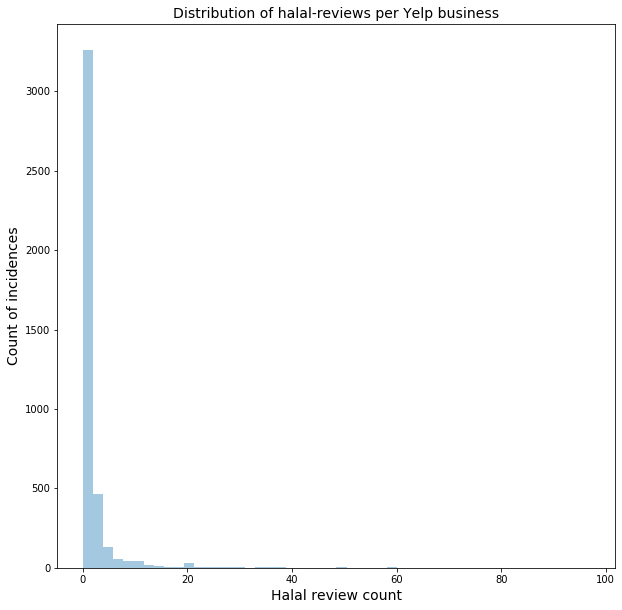

In [63]:
db = Database()

# get halal-reviews (reviews that include the word 'halal')
reviews_sql = '''SELECT * FROM reviews'''
reviews_df = db.select_df(reviews_sql)
print('- {} reviews contained the word Halal were scraped'.format(reviews_df.shape[0]))

# how many restaurants do these reviews cover
res_num = reviews_df['restaurant_id'].nunique()
print('- These reviews are from {} restaurants'.format(res_num))

# add column with num of scraped reviews per business
counts = reviews_df.restaurant_id.value_counts()
yelp_df = yelp_df.assign(halal_review_count=yelp_df.platform_id.map(dict(zip(counts.index, counts.values))))
yelp_df.halal_review_count = yelp_df.halal_review_count.fillna(0)

# plot histogram of counts per restaurant
plt.figure(figsize=(10,10))
g = sns.distplot(yelp_df.halal_review_count, kde = False)
g.set_title('Distribution of halal-reviews per Yelp business', size=14)
g.set_xlabel('Halal review count', size=14)
g.set_ylabel('Count of incidences', size=14)
# plt.plot([3, 3],[0, 3500], linewidth=2, linestyle='dashed', color='r') # cutoff between 2 & 5. To remove noise
plt.show()

# Match with Zabiha list
## Match based on name similarity an distance
### 1. Add coordinates and image_url data to restaurants of interest from Yelp

In [10]:
import Yelp_business_search
import json

# get yelp businesses
yelp_sql = '''SELECT * FROM businesses WHERE url LIKE '%yelp%' '''
yelp_df = db.select_df(yelp_sql)

halal_mask = yelp_df['platform_id'].isin(reviews_df['restaurant_id'].unique())
halal_df = yelp_df[halal_mask]

c=0
halal_df['image_url'] = None
for i, yelp_id in halal_df['platform_id'].iteritems():
    if pd.isna(halal_df.loc[i, 'image_url']):
        try:
            row = Yelp_business_search.get_yelp_business_details(yelp_id)
            halal_df.loc[i, 'image_url'] = row['image_url']
            halal_df.loc[i, 'lat'] = row['lat']
            halal_df.loc[i, 'lng'] = row['lng']
            time.sleep(0.2)
        except: # some API requests fail randomly and retry seems to fix the issue
            row = Yelp_business_search.get_yelp_business_details(yelp_id)
            halal_df.loc[i, 'image_url'] = row['image_url']
            halal_df.loc[i, 'lat'] = row['lat']
            halal_df.loc[i, 'lng'] = row['lng']
            time.sleep(0.2)
    c+=1
    print('[{0}/{1}] id:{2}'.format(c, halal_df.shape[0], yelp_id), end='\r', flush=True )

/Users/wesamazaizeh/miniconda3/envs/spacy_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### 2. update businesses database with image_url and coordinates columns

In [87]:
# manually added image_url and lat, lng columns via pgAdmin4

db_list = halal_df[['platform_id', 'image_url', 'lat', 'lng']]
update_sql = '''UPDATE businesses
                SET image_url = (%s),
                    lat = (%s),
                    lng = (%s)
                WHERE platform_id = (%s)'''
rows=[tuple(x) for x in db_list.values]
db.insert_rows(update_sql, *rows)

### 3. Distance and name similarity functions

In [89]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    dist = 12742 * asin(sqrt(a)) # [km]
    return dist

def closest(v, data):
    return min(data, key=lambda p: distance(v['lat'],v['lng'],data[p]['lat'],data[p]['lng']))


def similarity_score(name1, name2):
    s = SequenceMatcher(None, name1, name2).ratio()
    return s

### 4. Import Zabiha & MFoodies CSVs. Then, find closest Zabiha/ MFoodies to each restaurant-of-interest and name similairty score

In [96]:
#  import Zabiha & MFoodies lists
zabiha_df = pd.read_csv('/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/data/data_collection/target_feature/zabiha_list.csv')
zabiha_df['lat'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[0]))
zabiha_df['lng'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[1]))

mfoodies_df = pd.read_csv('/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/data/data_collection/target_feature/muslim_foodies_list.csv')
mfoodies_df['lat'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[0]))
mfoodies_df['lng'] = zabiha_df['coordinates'].apply(lambda x: float(x.split(',')[1]))

# make dict for faster processing
halal_dict = {row['name']: {'lat' : row.lat, 'lng' : row.lng}  for _,row in halal_df.iterrows()}
zabiha_dict = {row['name']: {'lat' : row.lat, 'lng' : row.lng}  for _,row in zabiha_df.iterrows()}
mfoodies_dict = {row['name']: {'lat' : row.lat, 'lng' : row.lng}  for _,row in mfoodies_df.iterrows()}


# find closest Zabiha/ Mfoodies to each restaurant-of-interest and calculate name similarity
c=0
for i, res_name in halal_df['name'].iteritems():
    res1 = closest(halal_dict[res_name], zabiha_dict)
    halal_df.loc[i, 'zabiha_name'] = res1
    halal_df.loc[i, 'zabiha_lat'] = zabiha_dict[res1]['lat']
    halal_df.loc[i, 'zabiha_lng'] = zabiha_dict[res1]['lng']
    halal_df.loc[i, 'zabiha_distance'] = distance(halal_df.loc[i, 'lat'], halal_df.loc[i, 'lng'],
                                           zabiha_dict[res1]['lat'], zabiha_dict[res1]['lng'])
    halal_df.loc[i, 'zabiha_similarity'] = similarity_score(res_name, res1)
    
    res2 = closest(halal_dict[res_name], mfoodies_dict)
    halal_df.loc[i, 'mfoodies_name'] = res2
    halal_df.loc[i, 'mfoodies_lat'] = mfoodies_dict[res2]['lat']
    halal_df.loc[i, 'mfoodies_lng'] = mfoodies_dict[res2]['lng']
    halal_df.loc[i, 'mfoodies_distance'] = distance(halal_df.loc[i, 'lat'], halal_df.loc[i, 'lng'],
                                           mfoodies_dict[res2]['lat'], mfoodies_dict[res2]['lng'])
    halal_df.loc[i, 'mfoodies_similarity'] = similarity_score(res_name, res2)
    c+=1
    print('Progress: {0}/{1}'.format(c, halal_df.shape[0]), end='\r', flush=True)

### 5. Plot distance vs name similarity score for restaurants-of-interest and find threshold

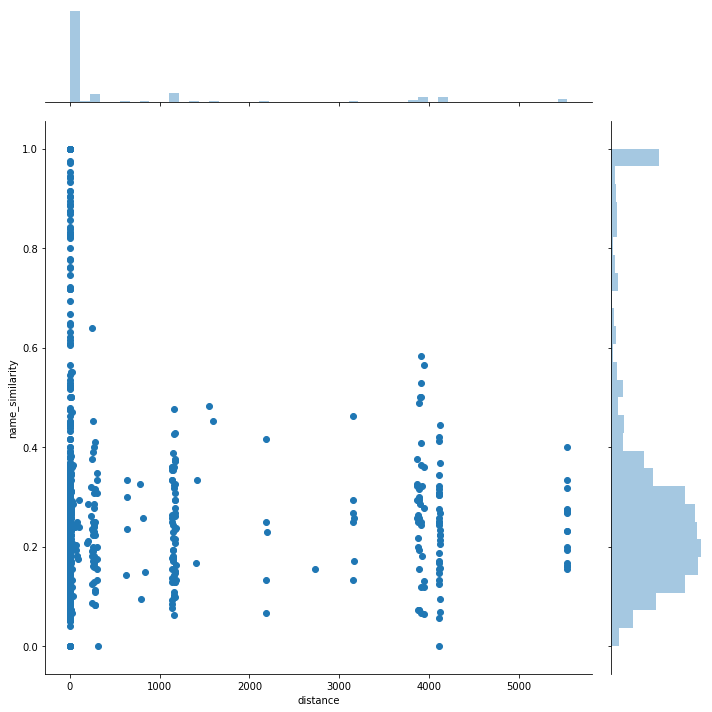

In [114]:
plot_df  = pd.DataFrame(columns=['platform_id', 'name', 'match_name', 'distance', 'name_similarity'])
plot_df[['platform_id', 'name']] = halal_df[['platform_id', 'name']]
plot_df.index = halal_df.index

for i, row in halal_df.iterrows():
    if row['zabiha_distance'] < row['mfoodies_distance']:
        plot_df.loc[i, ['match_name', 'distance', 'name_similarity']] = row[['zabiha_name', 'zabiha_distance', 'zabiha_similarity']].tolist()
    else:
        plot_df.loc[i, ['match_name', 'distance', 'name_similarity']] = row[['mfoodies_name', 'mfoodies_distance', 'mfoodies_similarity']].tolist()

a = sns.jointplot(y='name_similarity', x='distance', data=plot_df, height=10)
plt.show()

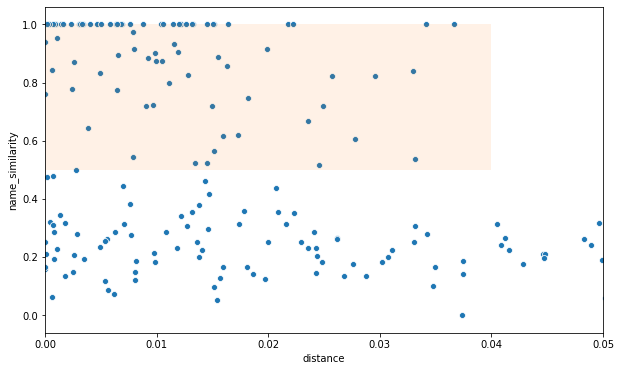

- Filter by distance less than to 400m and similarity score greater than 50%


In [152]:
plt.figure(figsize=(10,6))
sns.scatterplot(plot_df['distance'], plot_df['name_similarity'])
plt.xlim(0,0.05) 
plt.gca().fill_between((0,0.04), 0.5, 1, alpha=0.1) # within 170 meters and above 50% similarity
plt.show()

print('\033[1m- Filter by distance less than to 400m and similarity score greater than 50%\033[0m')

In [153]:
# sample of restaurants inside the shaded area
matched_df = plot_df[(plot_df['distance'] < 0.04) & (plot_df['name_similarity'] > 0.5)]
print('\033[1m{} restaurants best match Zabiha & MFoodies based on coordinate distance and name similarity\033[0m'.format(matched_df.shape[0]))
matched_df.head()

89 restaurants best match Zabiha & MFoodies based on coordinate distance and name similarity


,platform_id,name,match_name,distance,name_similarity
2,ctVgx_mIwt2Fwc48Pgjhlw,Gyro Mania,Gyro Mania,0.00688369,1
20,FdB6KDTEmX8HvomPwySAHg,Joloff Restaurant,Joloff,0.0134011,0.521739
22,KjqBMZ0bE9VV2VP3DrDZvg,First Oasis,First Oasis,0.0104265,1
30,R2VSWR_2bNhfchNqdgQR2g,Abir Halal Restaurant,Abir Halal,0.00383252,0.645161
36,M45jHhTaU6ePHDEibXk9nQ,Halal Paradise,Halal Paradise Truck,0.0295725,0.823529


### 6. Label matched restaurants and ones with 'halal' in the name

In [204]:
halal_df['halal'] = halal_df.apply(lambda row: True if row['platform_id'] in matched_df['platform_id'].tolist() else False, axis=1)
assert halal_df['halal'].sum() == 89

halal_df['halal'] = halal_df.apply(lambda row: True if 'halal' in row['name'].lower() else row['halal'], axis=1)
assert halal_df2['halal'].sum() == 234

234

### 7. Export to CSV file to manually label rest of restaurants-of-ineterest

In [314]:
file_path = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/target_feature/label_target.csv'
# halal_df.to_csv(file_path, index=False)

### 8. Summary after manual labeling

In [319]:
labeled_df = pd.read_csv(file_path, index_col=0)
labeled_df.head()

,name,platform_id,url,total_review_count,address,id,image_url,lat,lng,zabiha_name,...,zabiha_distance,zabiha_similarity,mfoodies_name,mfoodies_lat,mfoodies_lng,mfoodies_distance,mfoodies_similarity,halal,note_1,note_2
0,Peri Peri Grill House,KPGZ6zr6lUX9YROjGcUbtw,https://www.yelp.com/biz/peri-peri-grill-house...,146,"{""235 Malcolm X Blvd"",""Brooklyn, NY 11233""}",5178,https://s3-media3.fl.yelpcdn.com/bphoto/Pua9bm...,40.684740,-73.929160,Taj Masala,...,0.058642,0.129032,Krave Shack,40.721219,-73.984109,6.157025,0.125000,TRUE,And of course the best part of it all it's��_H...,NaN
2,Gyro Mania,ctVgx_mIwt2Fwc48Pgjhlw,https://www.yelp.com/biz/gyro-mania-bath-beach...,41,"{""2151 Bath Ave"",""Bath Beach, NY 11214""}",5180,https://s3-media4.fl.yelpcdn.com/bphoto/vlTRc6...,40.598944,-73.997939,Gyro Mania,...,0.006884,1.000000,Kabul Kabob House,40.703428,-74.011081,11.670833,0.148148,TRUE,NaN,NaN
3,Middle Eastern Halal Food,WekK6vHrQZ-81CijH2sGiw,https://www.yelp.com/biz/middle-eastern-halal-...,146,"{""8601 5th Ave"",""Brooklyn, NY 11209""}",5182,https://s3-media1.fl.yelpcdn.com/bphoto/Wi3R2J...,40.621258,-74.026194,Your House Caf��Ε�_,...,1.463746,0.146341,Kabul Kabob House,40.703428,-74.011081,9.225376,0.285714,TRUE,In name,NaN
20,Joloff Restaurant,FdB6KDTEmX8HvomPwySAHg,https://www.yelp.com/biz/joloff-restaurant-bro...,185,"{""1168 Bedford Ave"",""Brooklyn, NY 11216""}",5198,https://s3-media3.fl.yelpcdn.com/bphoto/fW320I...,40.684100,-73.954220,Joloff,...,0.013401,0.521739,Krave Shack,40.721219,-73.984109,4.835691,0.142857,TRUE,NaN,NaN
22,First Oasis,KjqBMZ0bE9VV2VP3DrDZvg,https://www.yelp.com/biz/first-oasis-brooklyn?...,169,"{""9218 4th Ave"",""Brooklyn, NY 11209""}",5200,https://s3-media1.fl.yelpcdn.com/bphoto/ETfkHV...,40.618030,-74.030650,First Oasis,...,0.010426,1.000000,Kabul Kabob House,40.703428,-74.011081,9.638222,0.071429,TRUE,NaN,NaN


In [320]:
labeled_df['halal'] = labeled_df['halal'].str.replace('FLASE', 'FALSE')
labeled_df['halal'] = labeled_df['halal'].apply(lambda x: True if x =='TRUE' else False)
labeled_df['halal'].value_counts()

True     613
False    225
Name: halal, dtype: int64

### 9. Possible features
#### based on notes from manually labeling the target feature
#### (+) seem to be associated with reviews from halal-restaurants. (-) seems to be associated with non-halal restaurants
- 'Halal' in business name (+)
- [{'LEMMA': 'be'},{'LOWER': 'halal'}] (+)
    - more tricky with abbreviations
- [{'LOWER': 'halal'}, {'lower': 'guy or guys or truck or trucks'}] (-)
    - might need to be more complex as detecting comparison in sentence
    - weight of 'halal guys'/ all 'halal'
    - 'halal guys sauce'
- ['halal chicken'] (-)
- ['halal burger'] (+)
- ['CreekStone' & 'burger'] (-)
- uncertanity in sentence (-)
- some of the meats are halal with 'is halal'
    - 'only' 'part of' 'some' 'few' (-) 
- not halal
    - negative in sentence is enough or have to use NER to narrow it down
- '100% halal' (+) and '50%/98% halal' (-)
- non halal terms
- halal as noun vs adj
    - compare from labeled data
- Token frequency count for each category to inform feature extraction 

In [311]:
import random
labeled_df.loc[[not x for x in labeled_df['halal']], 'note_1'].iloc[8]

"��_Good, but don't think it's worth the extra $$ over a��_halal��_cart."